<a href="https://colab.research.google.com/github/MedMaache/AI-Waste-Sorter/blob/main/Waste_Sorting_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Food Classifier


## Load and prepare Data

First we need to update the notebook to the latest version of fastai.

In [ ]:
!pip install -Uqq fastai
from fastai.vision.all import *

import matplotlib.pyplot as plt
import numpy as np
import PIL
import os

from google.colab import drive


In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import io
import html
import time

In [ ]:
import pathlib

from pathlib import Path
from PIL import UnidentifiedImageError

drive.mount("/content/gdrive", force_remount=True)
drive.mount('/content/gdrive')
data_dir = "gdrive/My Drive/trash-dataset-resized"
data_dir = pathlib.Path(data_dir)

Mounted at /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


At first we are downloading the Dataset.


In [ ]:
#How many images are we dealing with
len(get_image_files(data_dir))

3431

In [ ]:
#Deciding which two foods we want to classify
labelA = list(data_dir.glob('cardboard/*'))
labelB = list(data_dir.glob('glass/*'))
labelC = list(data_dir.glob('metal/*'))
labelD = list(data_dir.glob('paper/*'))
labelE = list(data_dir.glob('plastic/*'))
labelF = list(data_dir.glob('trash/*'))

**Some Data Preperation**

Next we're gonna do some preperation to make the data handling easier. It's not important that you understand the following code snippet completly.

We're just doing two things:


1.   Removing all images that don't have labelA, labelC labelD, labelE, labelF
2.   Renaming images to have that label in their filename



In [ ]:
#Loop through all Images downloaded
for img in get_image_files(data_dir):
  #Rename Images so that the Label (Samosa or Churros) is in the file name
  if 'cardboard' in str(img):
    img.rename(f"{img.parent}/{'cardboard'}-{img.name}")
  elif 'glass' in str(img):
    img.rename(f"{img.parent}/{'glass'}-{img.name}")
  elif 'metal' in str(img):
    img.rename(f"{img.parent}/{'metal'}-{img.name}")
  elif 'paper' in str(img):
    img.rename(f"{img.parent}/{'paper'}-{img.name}")
  elif 'plastic' in str(img):
    img.rename(f"{img.parent}/{'plastic'}-{img.name}")
  elif 'trash' in str(img):
    img.rename(f"{img.parent}/{'trash'}-{img.name}")
  else: os.remove(img) #If the Images are not part of labelA or labelB

len(get_image_files(data_dir))

3431

## Train Model

In [ ]:
def GetLabel(fileName):
  return fileName.split('-')[0]

GetLabel("cardboard-1.jpg") #Testing

'cardboard'

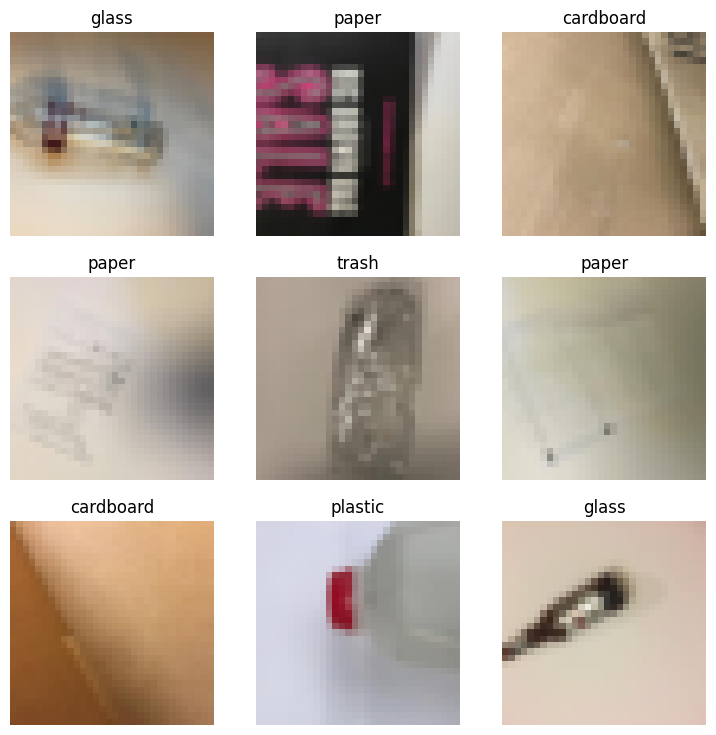

In [ ]:
dls = ImageDataLoaders.from_name_func(
    data_dir, get_image_files(data_dir), valid_pct=0.2, seed=420,
    label_func=GetLabel, item_tfms=Resize(32))

dls.train.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate, pretrained=True)
learn.fine_tune(epochs=1)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 74.2MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.100464,1.186171,0.384840,09:48


epoch,train_loss,valid_loss,error_rate,time
0,1.359473,1.034261,0.332362,00:19


Check out this while training to have look inside a Convolutional Neural Network.

https://distill.pub/2017/feature-visualization/

## Verify Model

### Capture Images

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  ## faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  #for (x,y,w,h) in faces:
      #img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

In [ ]:
label,_,probs = learn.predict(filename)

print(f"This is a {label}.")
print(f" cardboard {100*probs[0].item():.6f}%")
print(f" glass {100*probs[1].item():.6f}%")
print(f" metal {100*probs[2].item():.6f}%")
print(f" paper {100*probs[3].item():.6f}%")
print(f" plastic {100*probs[4].item():.6f}%")
print(f" trash {100*probs[5].item():.6f}%")

This is a cardboard.
 cardboard 56.856495%
 glass 2.959087%
 metal 3.172294%
 paper 3.278942%
 plastic 22.713387%
 trash 11.019799%


### Test using images in dataset

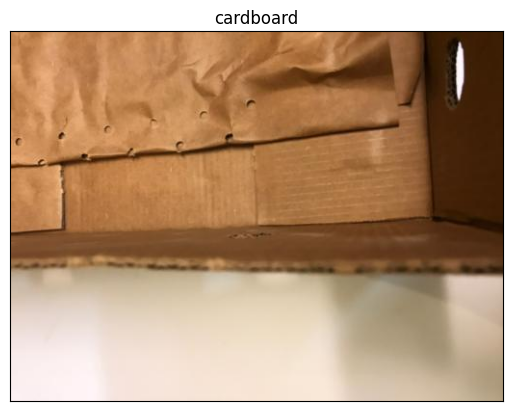

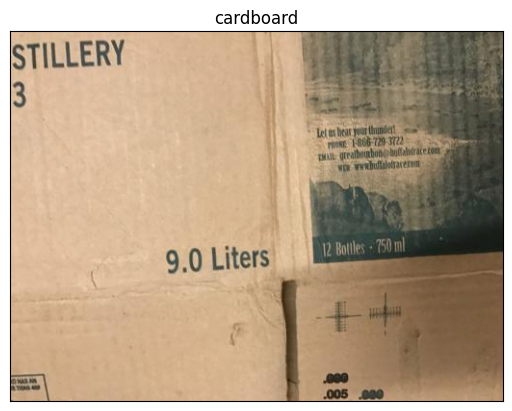

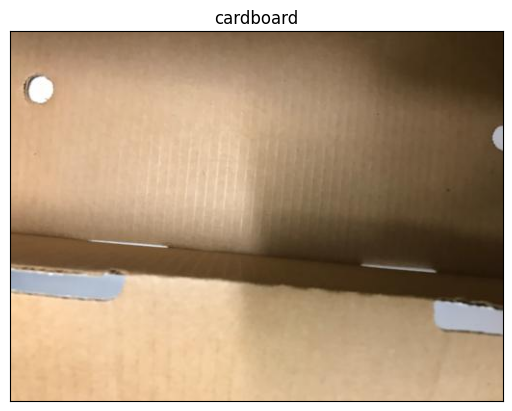

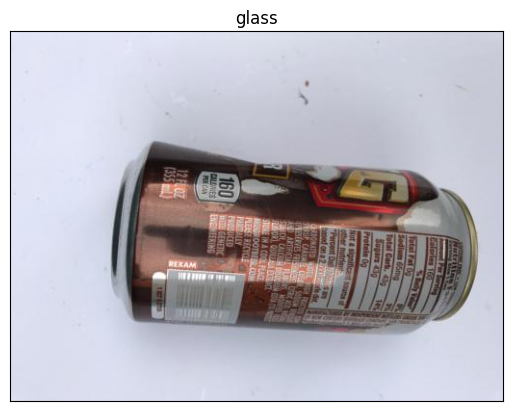

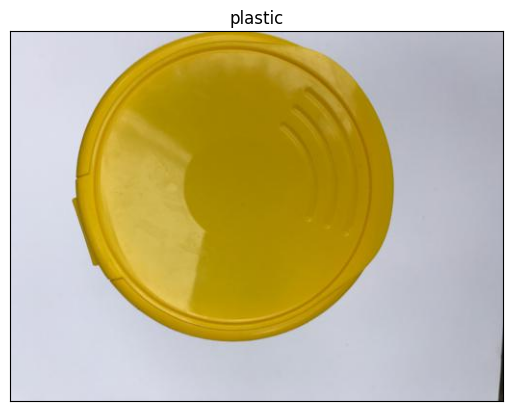

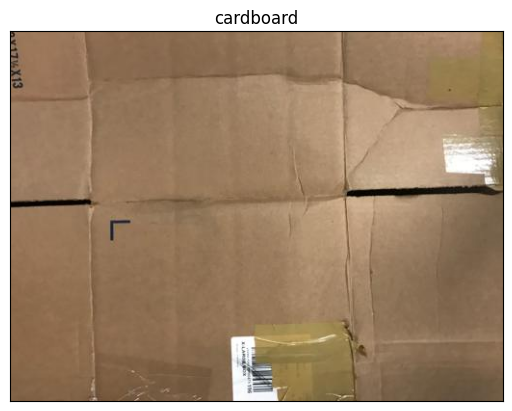

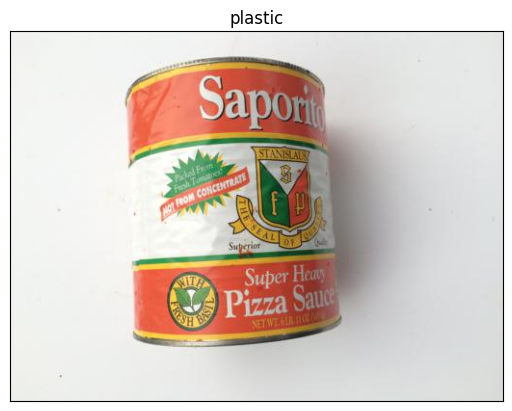

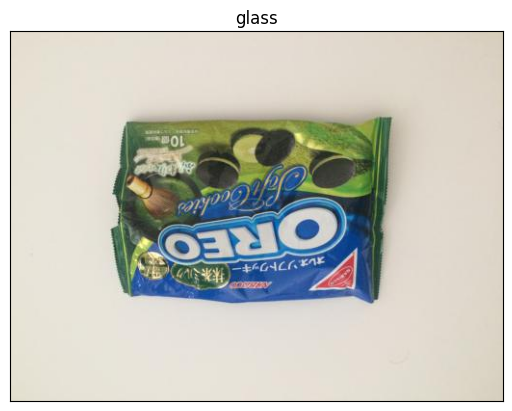

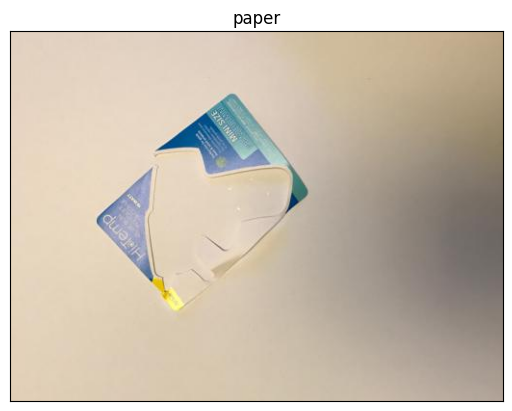

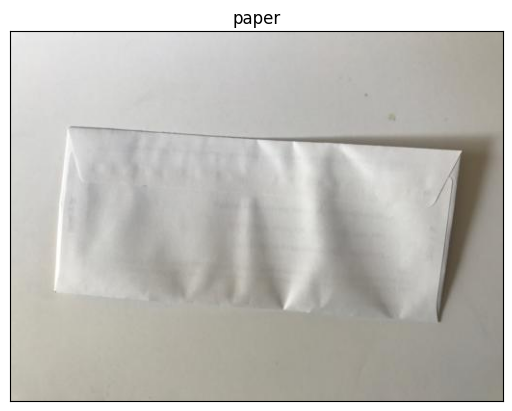

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(0,10):
  #Load random image
  randomIndex = random.randint(0, len(get_image_files(data_dir))-1)
  img = mpimg.imread(get_image_files(data_dir)[randomIndex])
  #Put into Model
  label,_,probs = learn.predict(img)

  #Create Figure using Matplotlib
  fig = plt.figure()
  ax = fig.add_subplot() #Add Subplot (For multiple images)
  imgplot = plt.imshow(img) #Add Image into Plot
  ax.set_title(label) #Set Headline to predicted label

  #Hide numbers on axes
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)

### Confusion Matrix (optional)

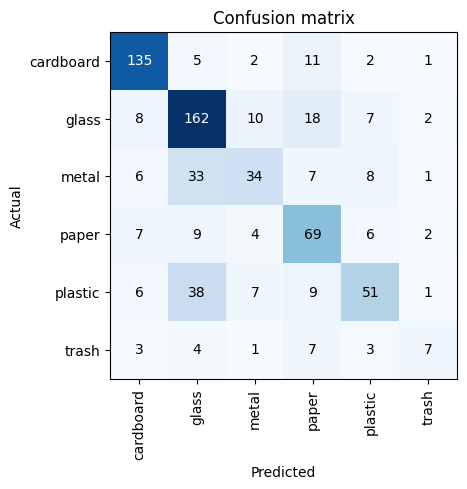

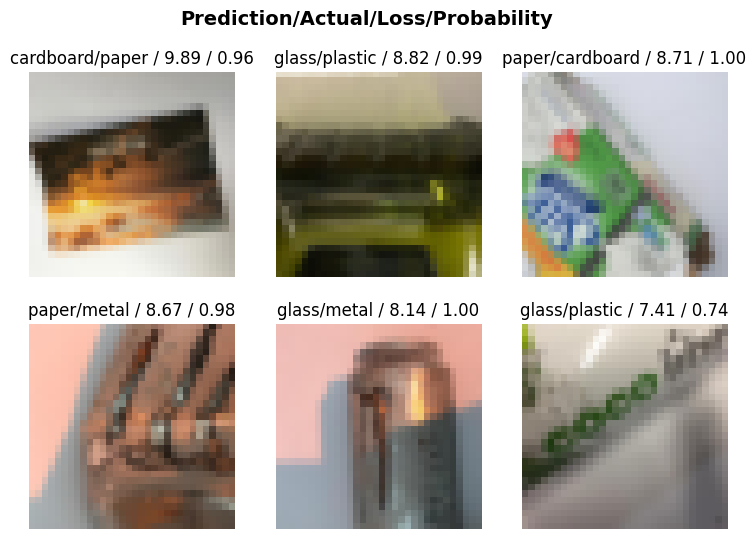

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(6)

## Deploy

In [ ]:
learn.export() #exports model as 'export.pkl' by default

In [ ]:
#let's grab the first pkl file we can find
modelPath = get_files(data_dir, '.pkl')[0]
modelPath

Path('gdrive/My Drive/trash-dataset-resized/export.pkl')

In [ ]:
learn_inf = load_learner(modelPath)
learn_inf.predict(mpimg.imread(get_image_files(data_dir)[0])) #raw prediction

('cardboard',
 tensor(0),
 tensor([9.8620e-01, 1.2479e-04, 3.2875e-03, 4.1124e-03, 4.3450e-04, 5.8397e-03]))

In [ ]:
learn_inf.dls.vocab #Get the labels

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
#This seems to only work properly in Chrome
from google.colab import files
files.download(modelPath)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Alternative download method
Download for non-chrome users only:

In [ ]:
shutil.move(str(modelPath), './')

This has moved the file. You should now be able to see it in the Colab File browser on the right and download it there.

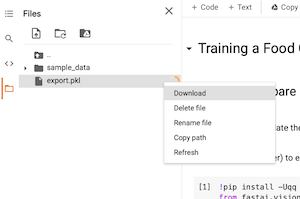